# Previsão de Demanda de Produtos nas Lojas 

## Objetivo

Prever as vendas dos produtos das diferentes lojas dos 3 primeiros meses do ano de 2018.

## Dataset

O dataset possui 5 anos de dados de vendas dos 50 diferentes produtos existentes em 10 lojas diferentes.

Link do dataset: <a href="https://www.kaggle.com/c/demand-forecasting-kernels-only/data"> Kaggle - Store Item Demand Forecasting Challenge </a>

## 1. Importando as Bibliotecas e os Dados

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import statsmodels.api as sm
import pylab

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

# uni os datasets em um
df = pd.concat([train, test], sort=False)

print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas', '\n')
train.head()

O dataset possui 958000 linhas e 5 colunas 



date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

## 2. Análise Exploratória dos Dados

### 2.1 Estatísticas Básicas

In [34]:
# Tempo de coleta dos dados
print(f'Os dados vão de {df["date"].min()} a {df["date"].max()}')

Os dados vão de 2013-01-01 00:00:00 a 2018-03-31 00:00:00


In [5]:
# Quantidade de produtos em cada loja
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

Insigths:

* Os dados vão de 2013 a março de 2018

* Temos 10 lojas, cada uma com 50 produtos

In [6]:
# Estatísticas resumidas para cada loja 
df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

Insigths:

* O valor máximo de vendas foi de 231 para a loja 2, e o valor mínimo de vendas foi de 0 para a loja 6.

* A maior média de vendas foi de 67 para a loja 2, e a menor média de vendas foi de 36 para a loja 7.

In [35]:
# Estatísticas resumidas para cada produto
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

Insigths:

* O valor máximo de vendas foi de 231 para o produto 15, e o valor mínimo de vendas foi de 59 para o produto 27.

* A maior média de vendas foi de 88 para o produto 15, e a menor média de vendas foi de 21 para o produto 1.

### 2.2 Histograma: Vendas por Loja 

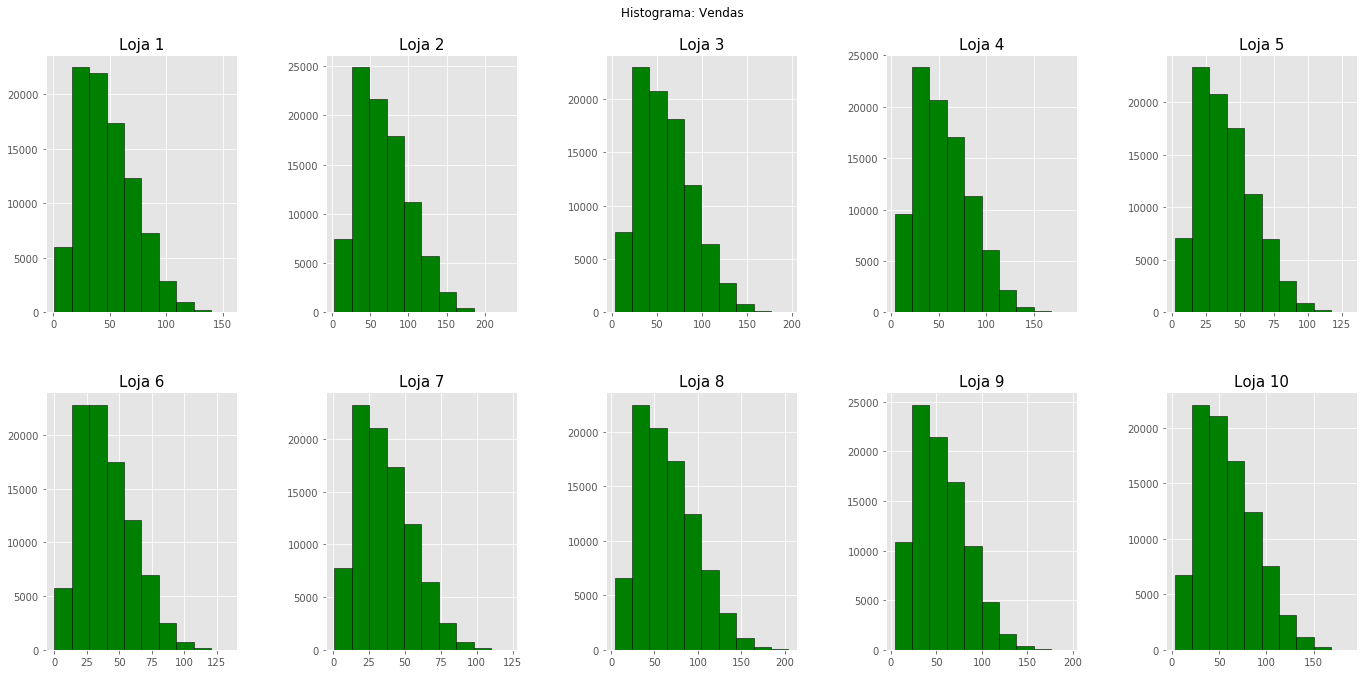

In [44]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1], color='green',edgecolor='black')
        axes[0,i-1].set_title("Loja " + str(i), fontsize = 15)
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6],color='green', edgecolor='black')
        axes[1,i-6].set_title("Loja " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histograma: Vendas");

Insigth:

* As 10 lojas realizam, com maior frequência, um número de 25 vendas

### 2.3 Distribuição das Vendas para cada Produto na 1ª Loja 


Vimos que existem dados de 10 diferentes lojas, seria inconveniente visualizar diretamente as vendas para todas elas. Iremos então fazer isso para apenas a loja 1.

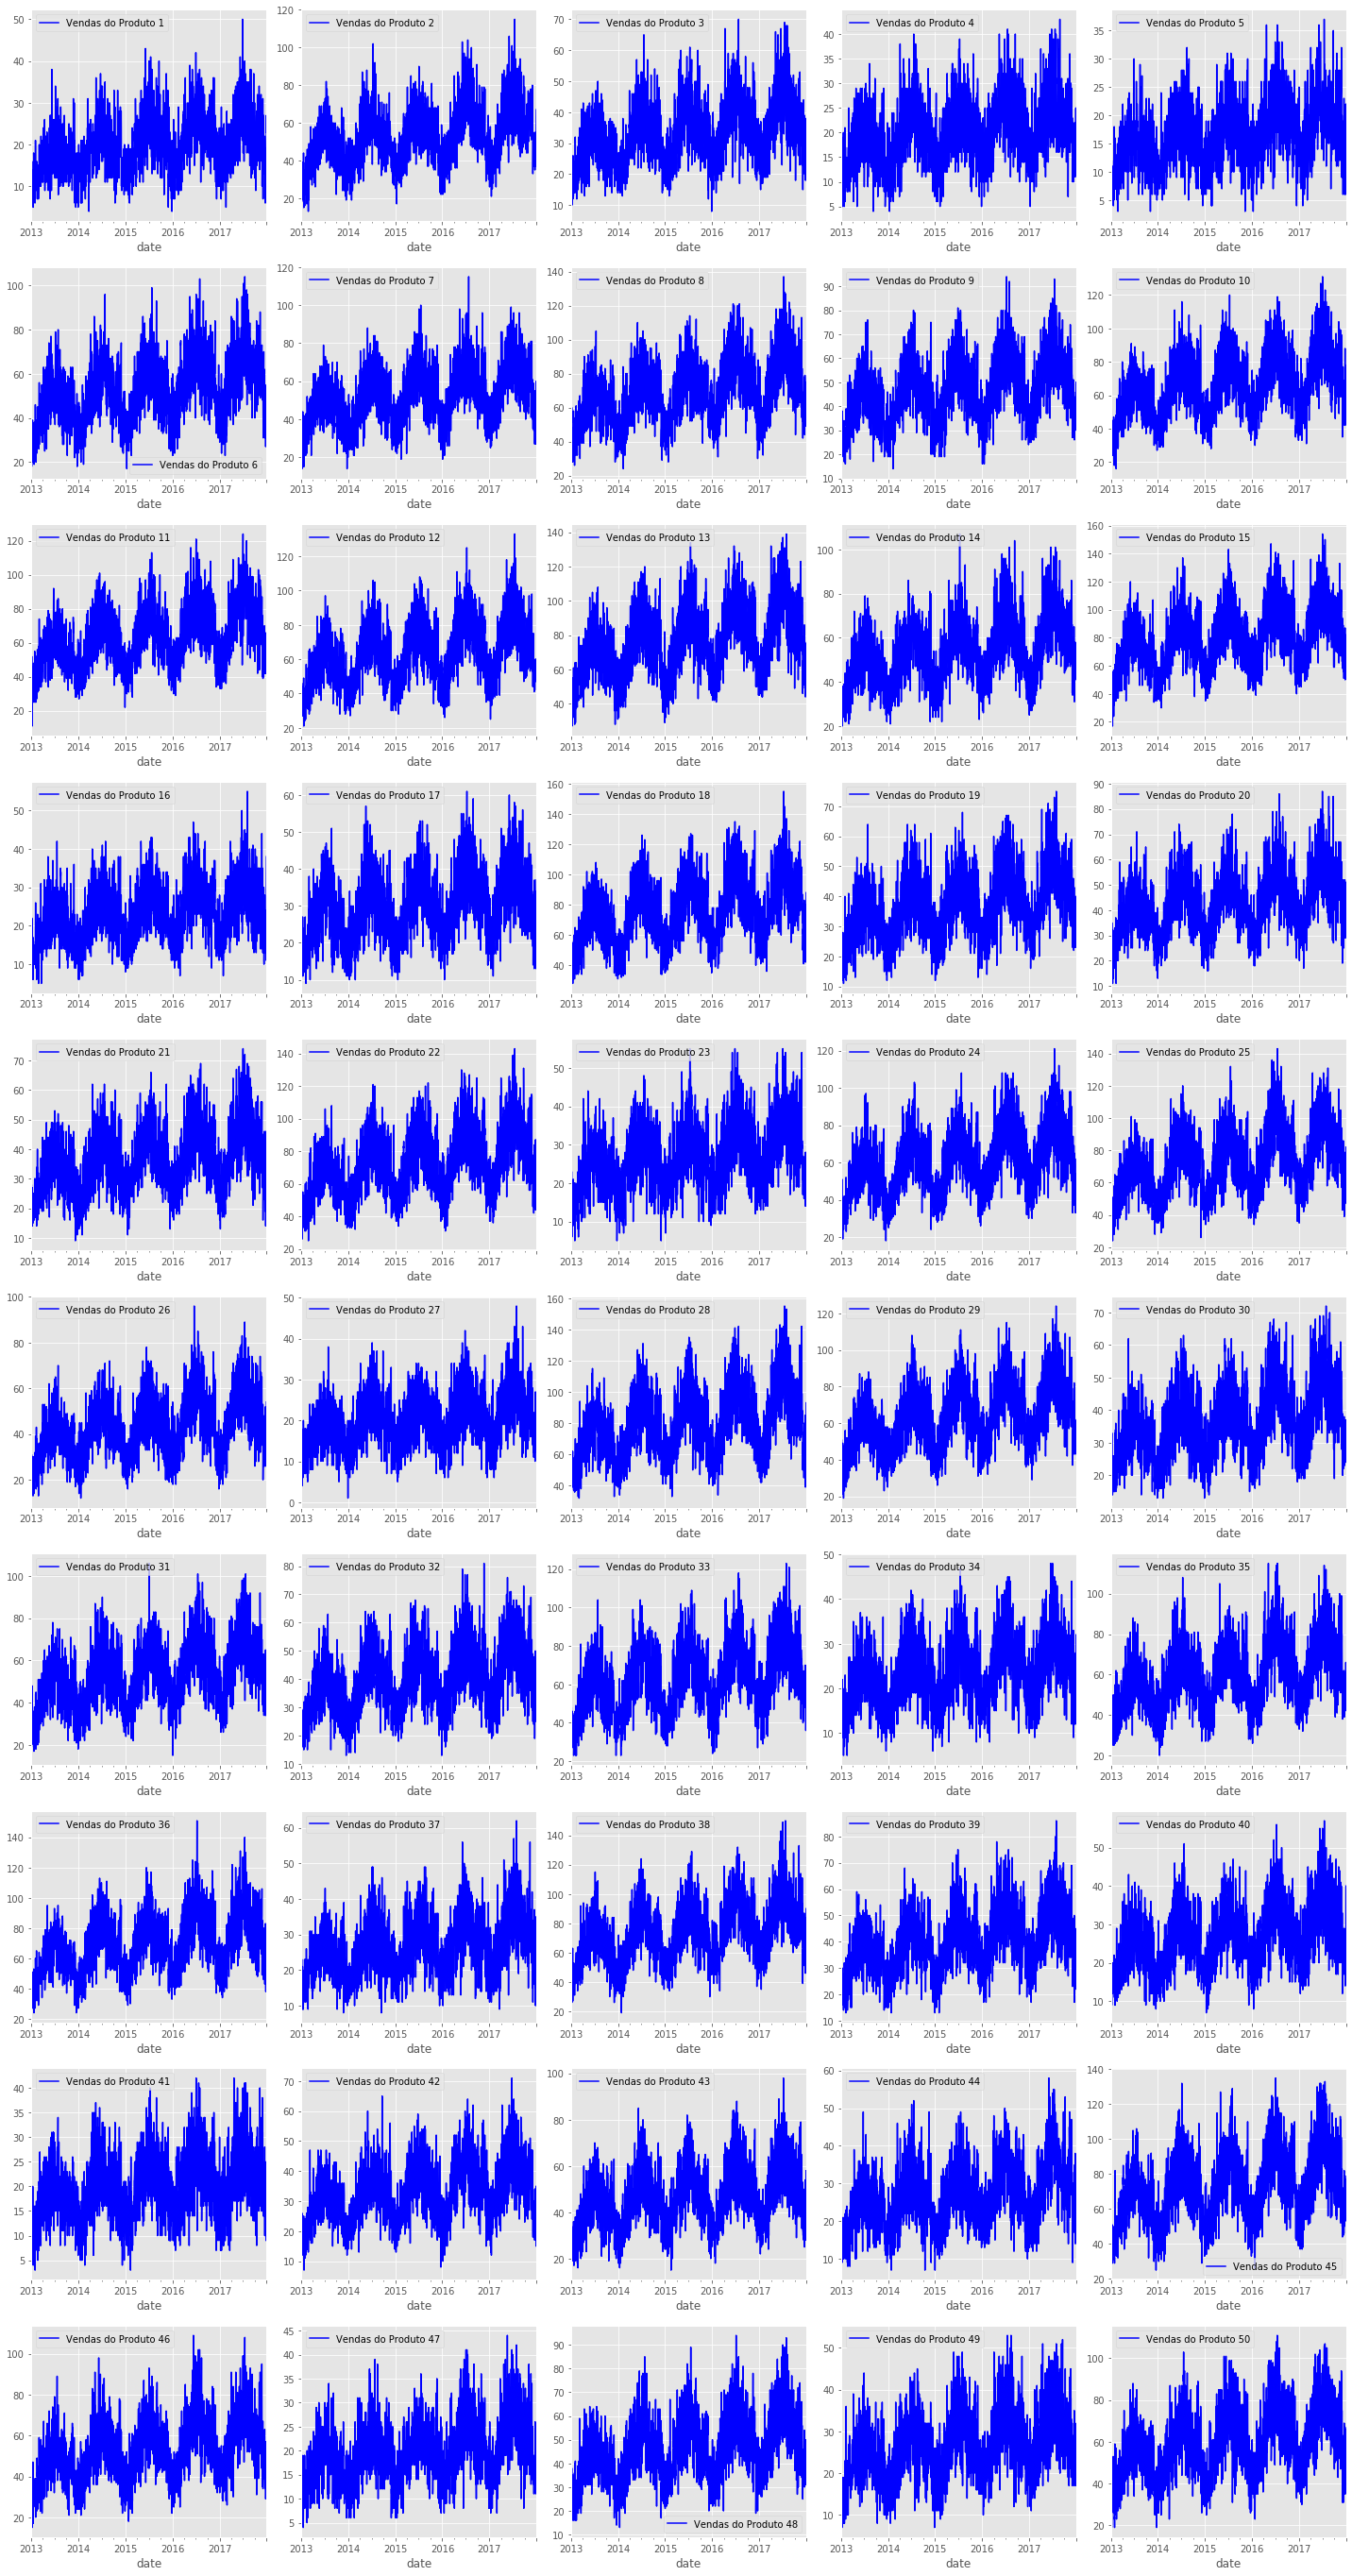

In [45]:
store = 1
sub = train[train.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(20, 38))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, color='blue', label = "Vendas do Produto "+str(i))
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, color='blue', label = "Vendas do Produto "+str(i))
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True,color='blue', label = "Vendas do Produto "+str(i))    
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True,color='blue', label = "Vendas do Produto "+str(i))    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True,color='blue', label = "Vendas do Produto "+str(i))  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True,color='blue', label = "Vendas do Produto "+str(i))    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True,color='blue', label = "Vendas do Produto "+str(i))    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True,color='blue', label = "Vendas do Produto "+str(i))    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True,color='blue', label = "Vendas do Produto "+str(i)) 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True,color='blue', label = "Vendas do Produto "+str(i)) 
plt.tight_layout()
plt.show()

Analisar as série temporais nos gráficos acima fica muito difícil, vamos então quebar as datas em diferentes períodos e analisar separadamente.

In [3]:
def create_date_features(df):
    df['month'] = df.date.dt.month # meses
    df['day_of_month'] = df.date.dt.day # dias do mês
    df['week_of_year'] = df.date.dt.weekofyear # semanas no ano
    df['day_of_week'] = df.date.dt.dayofweek + 1 # dias da semana
    df['year'] = df.date.dt.year # anos
    df["is_wknd"] = df.date.dt.weekday // 4 # se é dia de semana 
            
    # 0: Inverno - 1: Primavera - 2: Verão - 3: Outono (Estações no Hemisfério Norte)
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1) 
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9,10,11]), 3, df["season"])
    return df
df = create_date_features(df)

### 2.4 Analisando as Vendas por Períodos

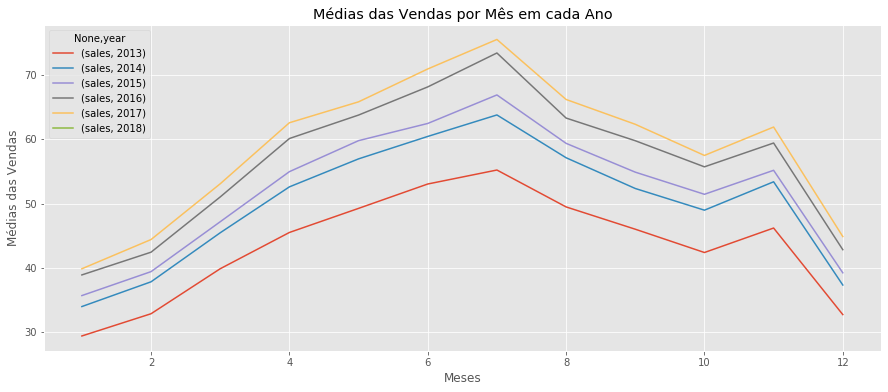

In [54]:
df.groupby(['month','year']).agg({'sales':'mean'}).unstack().plot(figsize=(15,6))
plt.title("Médias das Vendas por Mês em cada Ano")
plt.xlabel("Meses")
plt.ylabel("Médias das Vendas")
plt.show()

Insigths:

* No ano de 2017 as 10 lojas tiveram as maiores médias das vendas.

* No ano de 2013 as lojas tiveram as menores médias das vendas

* Julho (7) é o mês com maiores vendas e Janeiro (1) o mês de menor vendas.

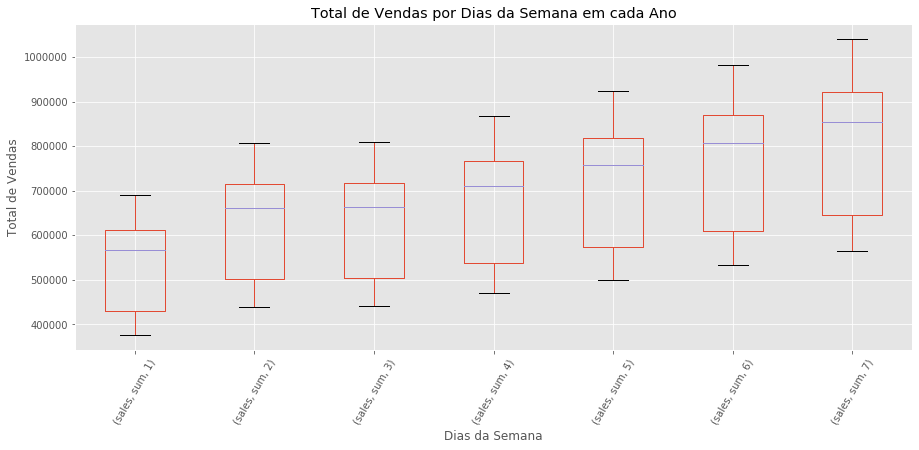

In [65]:
df.groupby(['store','day_of_week']).agg({'sales':['sum']}).unstack().plot(figsize=(15,6),kind='box',stacked=True)
plt.xticks(rotation=60)
plt.title("Total de Vendas por Dias da Semana em cada Ano")
plt.xlabel("Dias da Semana")
plt.ylabel("Total de Vendas")
plt.show()

Insigths:

* Para todos os anos, as vendas aumentam nos finais de semana (Sábado:6 e Domingo:7)

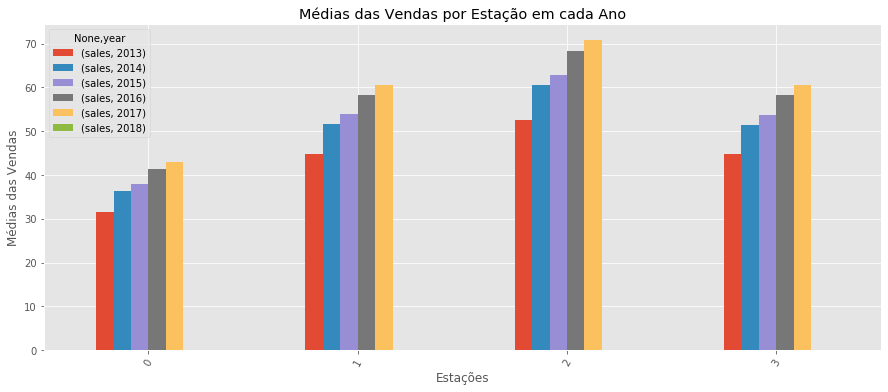

In [62]:
df.groupby(['season','year']).agg({'sales':'mean'}).unstack().plot(kind='bar',figsize=(15,6))
plt.title("Médias das Vendas por Estação em cada Ano")
plt.xlabel("Estações")
plt.xticks(rotation=60)
plt.ylabel("Médias das Vendas")
plt.show()

Insigth:

* Durante o verão (2) ocorrem as maiores vendas.

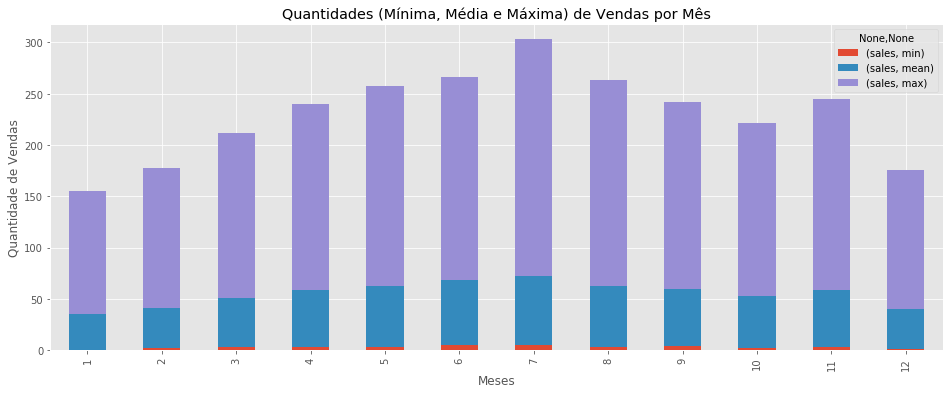

In [69]:
df.groupby('month').agg({'sales':['min','mean','max']}).plot(figsize=(16,6),kind='bar',stacked=True)
plt.title("Quantidades (Mínima, Média e Máxima) de Vendas por Mês")
plt.xlabel("Meses")
plt.ylabel("Quantidade de Vendas")
plt.show()

### 2.5 Analisando as Vendas por Produtos

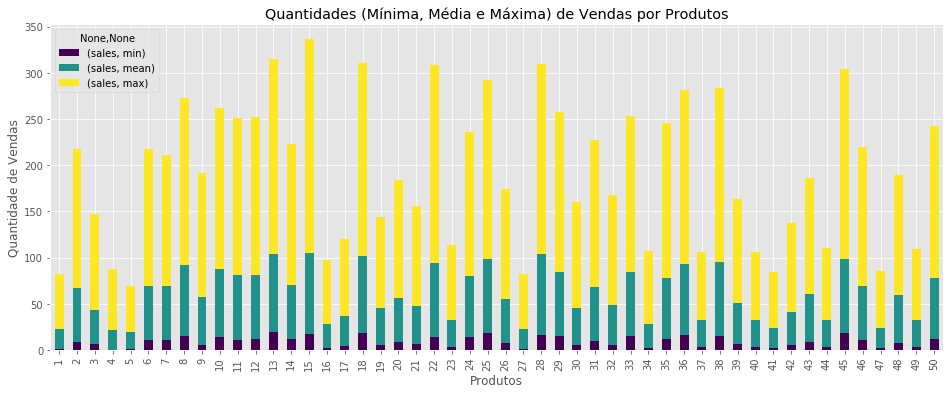

In [70]:
df.groupby('item').agg({'sales':['min','mean','max']}).plot(figsize=(16,6),kind='bar',stacked=True,cmap='viridis')
plt.title("Quantidades (Mínima, Média e Máxima) de Vendas por Produtos")
plt.xlabel("Produtos")
plt.ylabel("Quantidade de Vendas")
plt.show()

Insiths:

* O produto 15 obteve as maiores vendas.

* O produto 5 foi o menos vendido.

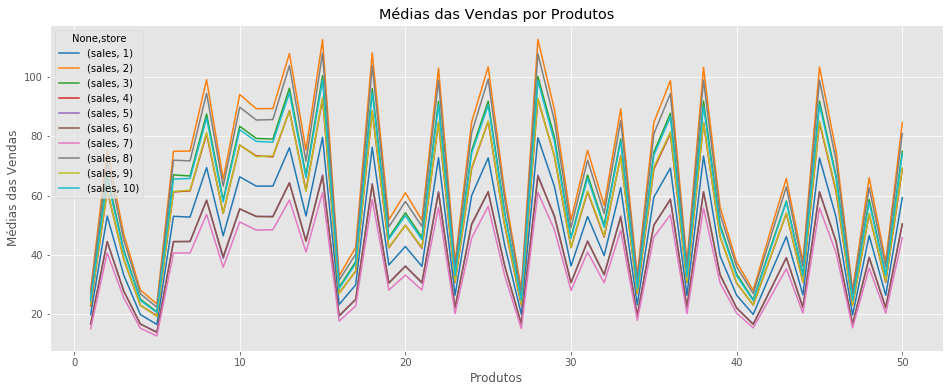

In [74]:
df.groupby(['item','store']).agg({'sales':'mean'}).unstack().plot(figsize=(16,6),kind='line', cmap='tab10')
plt.title("Médias das Vendas por Produtos em cada Loja")
plt.xlabel("Produtos")
plt.ylabel("Médias das Vendas")
plt.show()

Insith:

* A loja 2 teve as maiores médias de vendas para todos os produtos.

### 2.6 Janela Deslizante

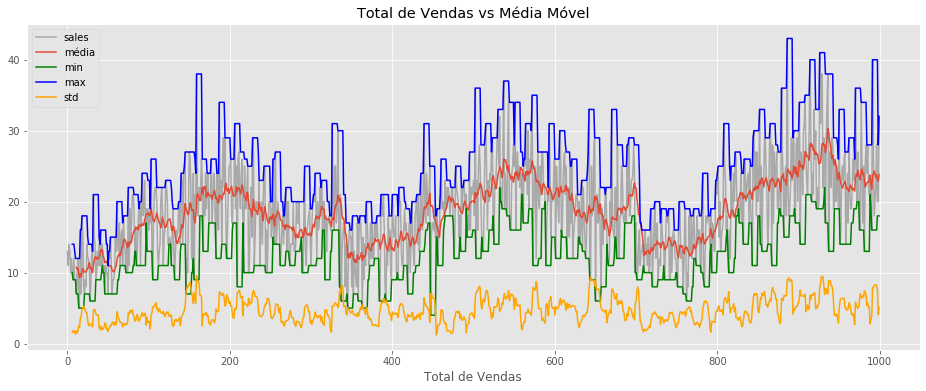

In [81]:
# Janela móvel
plt.figure(figsize=(16,6))
train['sales'].head(1000).plot(Label='Vendas',color='darkgray')
# janela mensal
train['sales'].head(1000).rolling(window=12).mean().plot(label='média')
# janela semanal
train['sales'].head(1000).rolling(window=7).min().plot(label='min',color='g')
train['sales'].head(1000).rolling(window=7).max().plot(label='max',color='b')
train['sales'].head(1000).rolling(window=7).std().plot(label='std',color='orange')
plt.legend()
plt.title("Total de Vendas vs Média Móvel")
plt.xlabel("Total de Vendas")
plt.show()

### 2.7 Correlação entre os Vendas Totais da Lojas

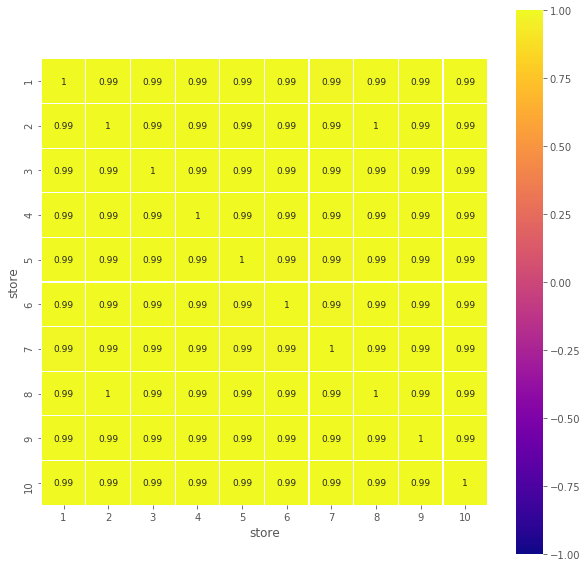

In [76]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr =  pd.pivot_table(storesales, values = "sales", columns="store", index="date").corr(method = "spearman")
plt.figure(figsize = (10,10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='plasma', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

Insigth:

* As vendas totais nas lojas estão altamente correlacionadas positivimente.


## 3. Engenharia de Recuros

Vamos criar novos recursos (variáveis) usando ponderação exponencial, que é um tipo de média móvel onde as observações passadas perdem o seu peso exponencialmente de acordo com o quanto é antiga, sendo o maior peso atribuído aos dados mais recentes.

In [4]:
# Função que fornece ponderação exponencial (EW). 
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5] # fatores e suaviação
lags = [91, 112, 180, 270, 365] # tempos de atrasos

df = ewm_features(df, alphas, lags)

## 4. Divisão em Treino - Validação e Função de Avaliação

In [5]:
# ordena em ordem cronológica
df = df.sort_values("date").reset_index(drop = True)

In [6]:
# Divide os dados em conjunto de treino e de validação
# conjunto de validação inclui 3 meses (Out., Nov. e Dec de 2017)
train = df.loc[(df["date"] < "2017-10-01"), :]
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]

In [7]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

print("Tamanho dos conjuntos")
print(f"Treino: X:{X_train.shape}, Y:{Y_train.shape}")
print(f"Validação: X:{X_val.shape}, Y:{Y_val.shape}")

Tamanho dos conjuntos
Treino: X:(867000, 33), Y:(867000,)
Validação: X:(46000, 33), Y:(46000,)


In [8]:
# função que calcula a métrica SMAPE: Erro percentual absoluto médio simétrico 
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

# função que aplica a métrica no modelo
def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

## 5. Primeiro Modelo

O modelo escolhido para este projeto foi o LigthGBM, que um modelo e gradient boosting desenvolvido pela Microsoft. Ele é baseado em algoritmos de árvore de decisão que acelera o treinamento. O foco do seu desenvolvimento está em ganho de desempenho e escalabilidade.

### 5.1 Sem Parâmetros

In [9]:
first_model = LGBMRegressor(random_state=384).fit(X_train, Y_train, 
                                                eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 13.97928842545412
VALID SMAPE: 13.114381582648402


* Mesmo sem usar hiperpaâmetros no modelo, conseguimos um um resultado com 13% de erro.

### 5.2 Importância dos Recursos

Aqui analisamos os recursos que mais influenciam na previsão do modelo.

In [10]:
def plot_lgb_importances(model, plot=False, num=10):
        
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                        feature  split       gain
32   sales_ewm_alpha_05_lag_365    214  64.633654
18    sales_ewm_alpha_08_lag_91     34   6.729271
23    sales_ewm_alpha_07_lag_91     45   6.597651
5                   day_of_week    257   6.548976
28    sales_ewm_alpha_05_lag_91    212   5.717030
2                         month    320   1.469784
31   sales_ewm_alpha_05_lag_270    164   1.117804
7                        season    104   1.072609
27   sales_ewm_alpha_07_lag_365     60   0.976143
1                          item    456   0.883657
9   sales_ewm_alpha_095_lag_112     18   0.704345
4                  week_of_year    109   0.393043
29   sales_ewm_alpha_05_lag_112    182   0.389546
11  sales_ewm_alpha_095_lag_270      9   0.382724
30   sales_ewm_alpha_05_lag_180    129   0.340233
10  sales_ewm_alpha_095_lag_180      9   0.334784
24   sales_ewm_alpha_07_lag_112     24   0.287036
14   sales_ewm_alpha_09_lag_112      9   0.283093
8    sales_ewm_alpha_095_lag_91    101   0.237978


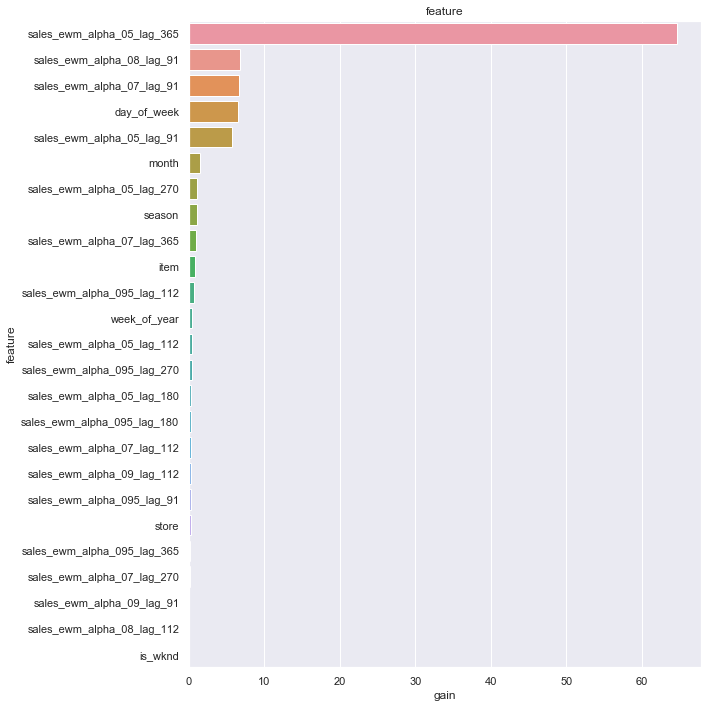

In [11]:
plot_lgb_importances(first_model, plot=True, num=30)


## 5.3 Análise de Erros

Vamos calcular as estatísticas da previsão do primeiro modelo.

In [42]:
error = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":first_model.predict(X_val)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)

error.sort_values("error", ascending=False).head(20)

date  store  item  actual        pred      error
31170 2017-12-02      9    29    45.0   85.274325  40.274325
17823 2017-11-05      8    25   168.0  128.444004  39.555996
28043 2017-11-26      8     6   135.0   96.407498  38.592502
30537 2017-12-01      8    28    70.0  108.355270  38.355270
9522  2017-10-20      2    45    99.0  136.932283  37.932283
31672 2017-12-03      4    38    57.0   94.870250  37.870250
6715  2017-10-14      3    13    89.0  125.872577  36.872577
31127 2017-12-02     10    50    49.0   85.164076  36.164076
27580 2017-11-25      1    28   142.0  105.910016  36.089984
23279 2017-11-16      3    24    57.0   93.049186  36.049186
35410 2017-12-10      8    48    36.0   71.293268  35.293268
45052 2017-12-30      3    24   108.0   72.799313  35.200687
24692 2017-11-19      4    25    87.0  122.038188  35.038188
28208 2017-11-26     10    43    52.0   86.865225  34.865225
28877 2017-11-27      3    45   118.0   83.176559  34.823441
41446 2017-12-22      9    15   116.0   81.301887  34.698113
24833 2017-11-19      9    25   149.0  114.364069  34.635931
7208  2017-10-15      8    18   110.0  144.442331  34.442331
24135 2017-11-18      3    15   160.0  125.720633  34.279367
21238 2017-11-12      2    22   113.0  147.273629  34.273629

* Na tabela acima, podemos comparar os valores das venas reais e das previsões, juntamente com o erro associado.

In [44]:
error[["actual", "pred", "error"]].describe([0.7, 0.8, 0.9, 0.95, 0.99]).T

count       mean        std       min        50%        70%  \
actual  46000.0  54.677543  28.485947  3.000000  50.000000  68.000000   
pred    46000.0  55.836301  27.879842  9.680116  51.290382  69.354224   
error   46000.0   6.278739   5.165367  0.000400   5.002531   7.903839   

              80%        90%         95%         99%         max  
actual  79.000000  95.000000  109.000000  132.000000  174.000000  
pred    80.079239  96.093688  108.301490  128.365603  158.132302  
error   10.000276  13.306397   16.443557   22.923608   40.274325

* Vemos que as estatísticas entre as previsões são coerentes com as dos valores reais, incluse a média do erro foi de apenas 6%.

In [46]:
# Erro das previsões de vendas para cada loja
error.groupby(["store"]).error.mean().sort_values(ascending = False)

store
8     7.121832
2     7.118854
3     6.747442
10    6.650425
9     6.599772
4     6.513352
1     5.925440
5     5.499181
6     5.408921
7     5.202170
Name: error, dtype: float64

* As previsões das vendas com menor erro foi da loja 7.

* A previsões das vendas com maior erro foi na loja 8.

In [47]:
# Erro das previsões de vendas para cada produto
error.groupby(["item"]).error.mean().sort_values(ascending = False)

item
28    8.657249
13    8.373888
45    8.341075
15    8.337891
38    8.252430
25    8.220206
18    8.054154
8     7.948581
22    7.915751
10    7.884265
36    7.878304
29    7.625821
12    7.471118
33    7.437609
24    7.424341
11    7.257765
50    7.225760
35    7.079193
6     6.821973
7     6.807666
2     6.714651
31    6.675990
9     6.661879
46    6.615457
14    6.473647
43    6.334795
26    6.257521
48    6.180974
20    6.002753
39    5.935302
32    5.846445
30    5.608298
42    5.566828
19    5.538192
21    5.466321
3     5.437096
17    5.171021
40    4.916991
23    4.915090
37    4.755364
49    4.633911
44    4.602025
16    4.381644
34    4.257742
41    4.233412
27    4.031160
47    4.016226
4     4.015992
1     3.916926
5     3.758245
Name: error, dtype: float64

* As previsões das vendas com menor erro foi do produto 5.

* A previsões das vendas com maior erro foi do produto 28.

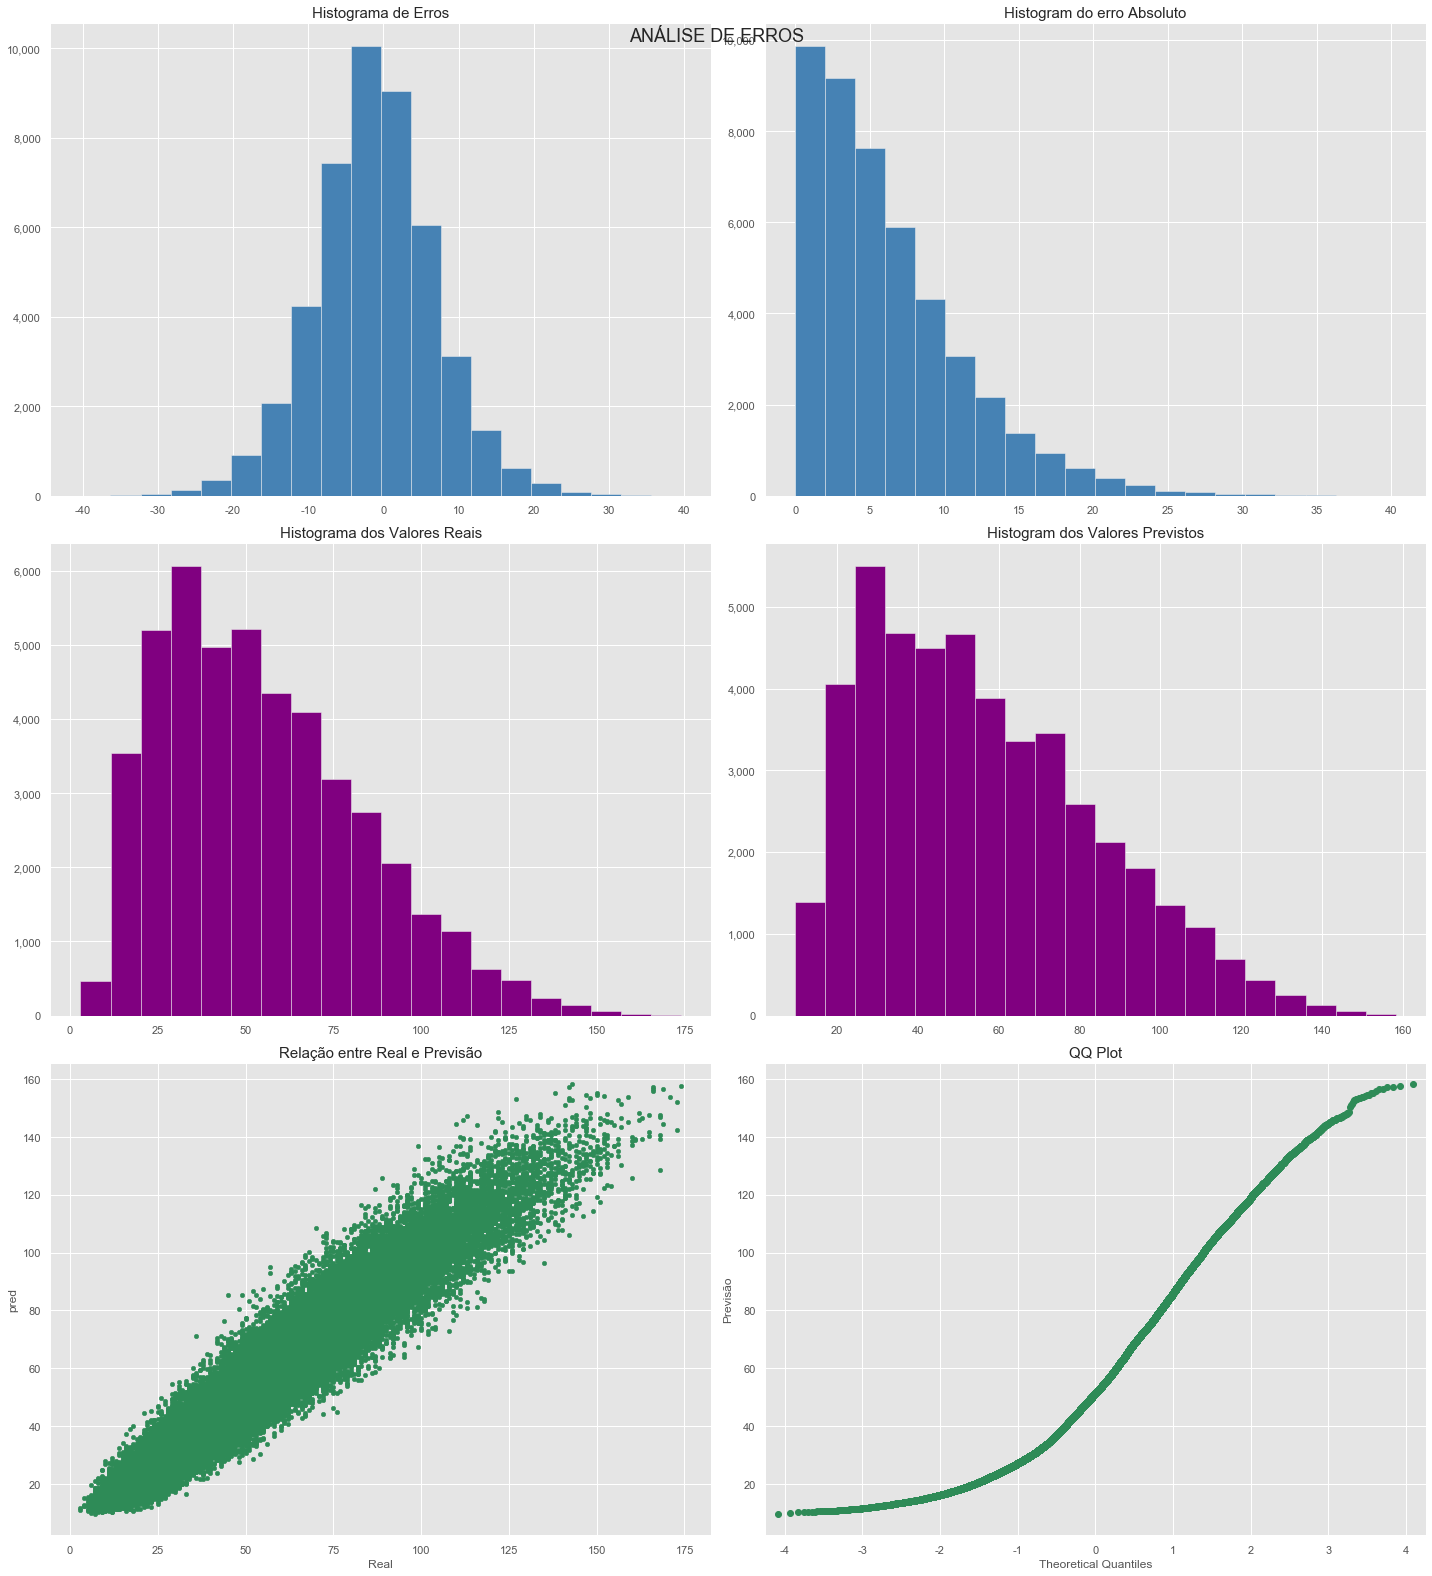

In [56]:
fig, axes = plt.subplots(3, 2, figsize = (20,22))
for axi in axes.flat:
    axi.ticklabel_format(style="sci", axis="y", scilimits=(0,10))
    axi.ticklabel_format(style="sci", axis="x", scilimits=(0,10))
    axi.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    axi.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
(error.actual-error.pred).hist(ax = axes[0, 0], color = "steelblue", bins = 20)
error.error.hist(ax = axes[0,1], color = "steelblue", bins = 20)

error.actual.hist(ax = axes[1, 0], color = "purple", bins = 20)
error.pred.hist(ax = axes[1, 1], color = "purple", bins = 20)
error.plot.scatter(x = "actual",y = "pred", color = "seagreen", ax = axes[2,0]);

# QQ Plot
sr = error.copy()
sm.qqplot(sr.pred, ax = axes[2,1], c = "seagreen")
plt.suptitle("ANÁLISE DE ERROS", fontsize = 18)
axes[0,0].set_title("Histograma de Erros", fontsize = 15)
axes[0,1].set_title("Histogram do erro Absoluto", fontsize = 15)
axes[1,0].set_title("Histograma dos Valores Reais", fontsize = 15)
axes[1,1].set_title("Histogram dos Valores Previstos", fontsize = 15)
axes[2,0].set_title("Relação entre Real e Previsão", fontsize = 15)
axes[2,1].set_title("QQ Plot", fontsize = 15)
axes[2,0].set_xlabel("Real", fontsize = 12)
axes[2,1].set_ylabel("Previsão", fontsize = 12)
fig.tight_layout()
plt.show()

* Os erros formam uma distribuição semelhante a uma Gaussiana centrada em zero.

* A maior frequência do histograma dos erros absolutos é de valor zero.

* Os histogramas das distribuições dos valores reais e dos previstos possuem forma semelhante

* A relação entre os reais e os previsto é positiva mas não chega a ser igual

* O QQ-Plot não forma uma linha reta, assim não temos uma distribuição normal perfeita para os erros.

Por fim, podemos realizar comparar graficamente as previsões do primeiro modelo com os valores reais das vendas

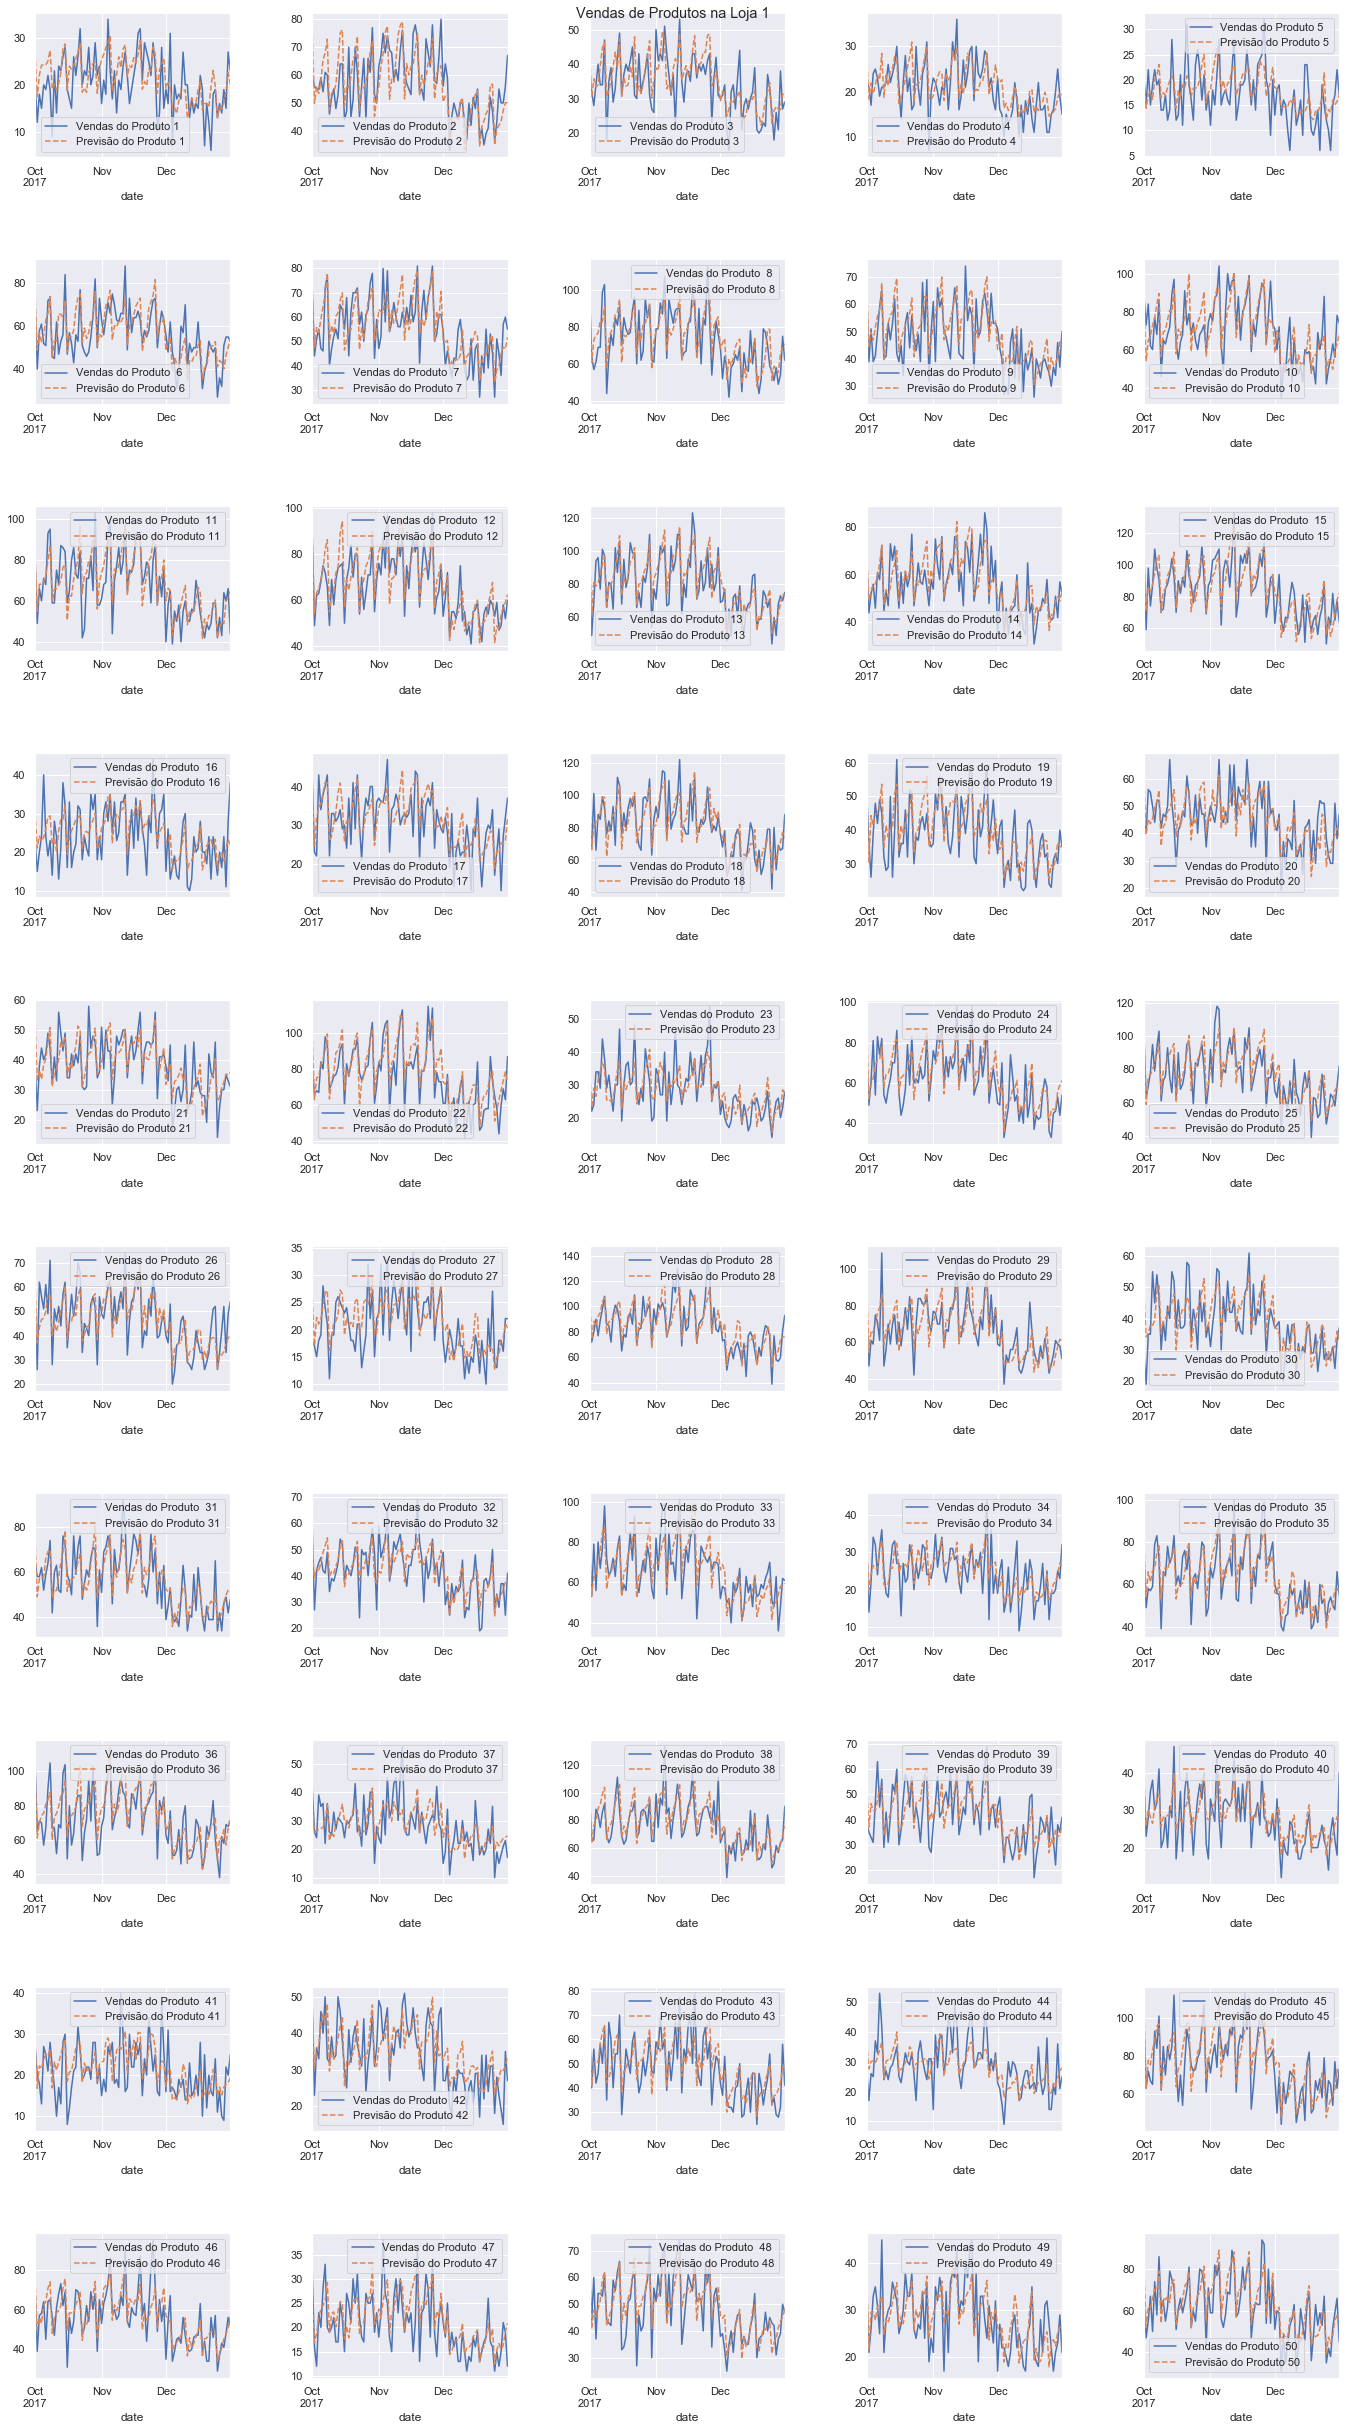

In [48]:
sub = error[error.store == 1].set_index("date")
fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].actual.plot(ax=axes[0, i-1], legend=True, label = "Vendas do Produto "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[0, i - 1], legend=True, label="Previsão do Produto " + str(i), linestyle = "dashed")
    if i >= 6 and i<11:
        sub[sub.item == i].actual.plot(ax=axes[1, i - 6], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[1, i - 6], legend=True, label="Previsão do Produto " + str(i),  linestyle="dashed")
    if i >= 11 and i<16:
        sub[sub.item == i].actual.plot(ax=axes[2, i - 11], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[2, i - 11], legend=True, label="Previsão do Produto " + str(i), linestyle="dashed")
    if i >= 16 and i<21:
        sub[sub.item == i].actual.plot(ax=axes[3, i - 16], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[3, i - 16], legend=True, label="Previsão do Produto " + str(i), linestyle="dashed")
    if i >= 21 and i<26:
        sub[sub.item == i].actual.plot(ax=axes[4, i - 21], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[4, i - 21], legend=True, label="Previsão do Produto " + str(i), linestyle="dashed")
    if i >= 26 and i<31:
        sub[sub.item == i].actual.plot(ax=axes[5, i - 26], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[5, i - 26], legend=True, label="Previsão do Produto " + str(i), linestyle="dashed")
    if i >= 31 and i<36:
        sub[sub.item == i].actual.plot(ax=axes[6, i - 31], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[6, i - 31], legend=True, label="Previsão do Produto " + str(i), linestyle="dashed")
    if i >= 36 and i<41:
        sub[sub.item == i].actual.plot(ax=axes[7, i - 36], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[7, i - 36], legend=True, label="Previsão do Produto " + str(i), linestyle="dashed")
    if i >= 41 and i<46:
        sub[sub.item == i].actual.plot(ax=axes[8, i - 41], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[8, i - 41], legend=True, label="Previsão do Produto " + str(i),linestyle="dashed")
    if i >= 46 and i<51:
        sub[sub.item == i].actual.plot(ax=axes[9, i - 46], legend=True, label = "Vendas do Produto  "+str(i))
        sub[sub.item == i].pred.plot(ax=axes[9, i - 46], legend=True, label="Previsão do Produto " + str(i),linestyle="dashed")
plt.tight_layout(pad=4.5)
plt.suptitle("Vendas de Produtos na Loja 1");
plt.show()

## 6. Próximo Modelo

### 6.1 Sem Parâmetros e Seleção de Recursos 

Uma vez que encontramos quais os recursos que de fato influenciam no modelo, podemos ajustar nosso modelo usando apenas esses recursos e tenta assim melhorar o desempenho do modelo.

In [14]:
# seleciona os recursos com ganho maior que 0.02
cols = feature_imp_df[feature_imp_df.gain > 0.02].feature.tolist()
print("Independent Variables:", len(cols))

second_model = LGBMRegressor(random_state=384).fit(
    X_train[cols], Y_train, 
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

Independent Variables: 27
TRAIN SMAPE: 13.948814307935553
VALID SMAPE: 13.12773916130347


### 6.2 Com Hiperparâmetros

Agora vamos ajustar os hiperparâmetros no modelo.

In [16]:
model_tuned = LGBMRegressor(num_leaves=31, n_estimators=500, max_depth=20, random_state=384, metric = "custom")
              
model_tuned.fit(
    X_train[cols], Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set = [(X_train[cols], Y_train), (X_val[cols], Y_val)],
    eval_names = ["Train", "Valid"],
    early_stopping_rounds= 300, verbose = 100
)
print("Best Iteration:", model_tuned.booster_.best_iteration)

Training until validation scores don't improve for 300 rounds
[100]	Train's SMAPE: 13.9724	Valid's SMAPE: 13.1218
[200]	Train's SMAPE: 13.4636	Valid's SMAPE: 12.8289
[300]	Train's SMAPE: 13.2858	Valid's SMAPE: 12.7072
[400]	Train's SMAPE: 13.1699	Valid's SMAPE: 12.6367
[500]	Train's SMAPE: 13.0962	Valid's SMAPE: 12.5994
Did not meet early stopping. Best iteration is:
[500]	Train's SMAPE: 13.0962	Valid's SMAPE: 12.5994
Best Iteration: 500


### 7. Modelo Final

Já encontramos os recursos mais influentes e ajustamos os parâmetros, podemos agora construir o modelo final.

### 7.1 Rodando o modelo final

In [17]:
df.sort_values(["store", "item", "date"], inplace = True)

train_final = df.loc[(df["date"] < "2018-01-01"), :]
test_final = df.loc[(df["date"] >= "2018-01-01"), :]

X_train_final = train_final[cols]
Y_train_final = train_final.sales
X_test_final = test_final[cols]

final_model = LGBMRegressor(num_leaves=31, n_estimators=500, max_depth=20, random_state=384, metric = "custom")
final_model.set_params(n_estimators=model_tuned.booster_.best_iteration) 
final_model.fit(X_train_final[cols], Y_train_final,
                eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

LGBMRegressor(max_depth=20, metric='custom', n_estimators=500, random_state=384)

## 8. Fazendo as Previsões Finais das Vendas em 2018

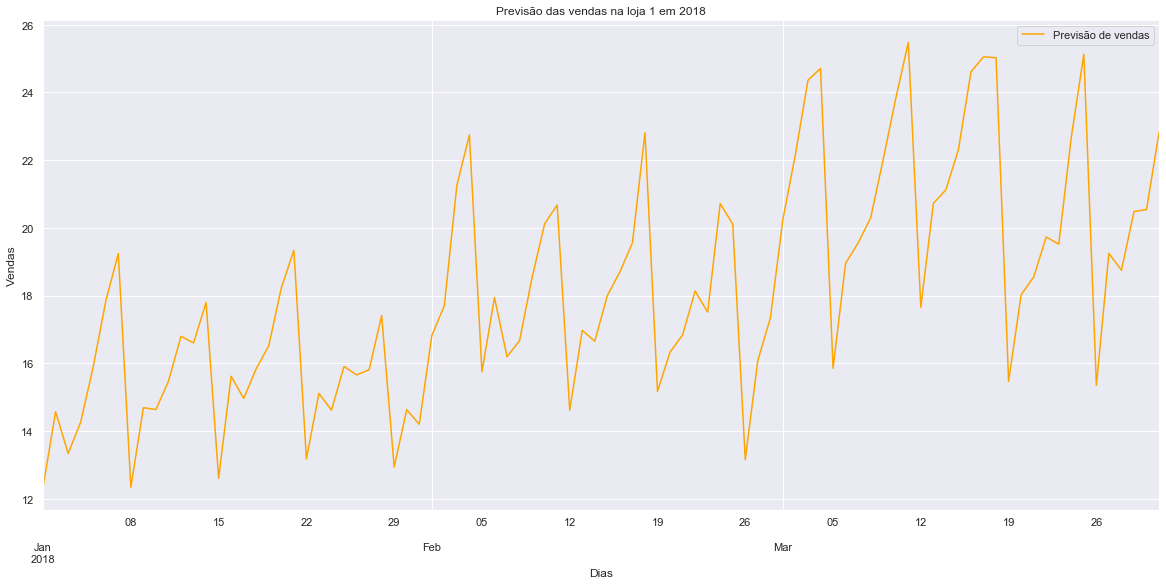

In [39]:
forecast = pd.DataFrame({
    "date":test_final.date,
    "store":test_final.store,
    "item":test_final.item,
    "sales":final_model.predict(X_test_final)
})

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "orange", figsize = (20,9),legend=True, label = "Previsão de vendas")
plt.title("Previsão das vendas na loja 1 em 2018")
plt.ylabel("Vendas")
plt.xlabel("Dias")
plt.show()

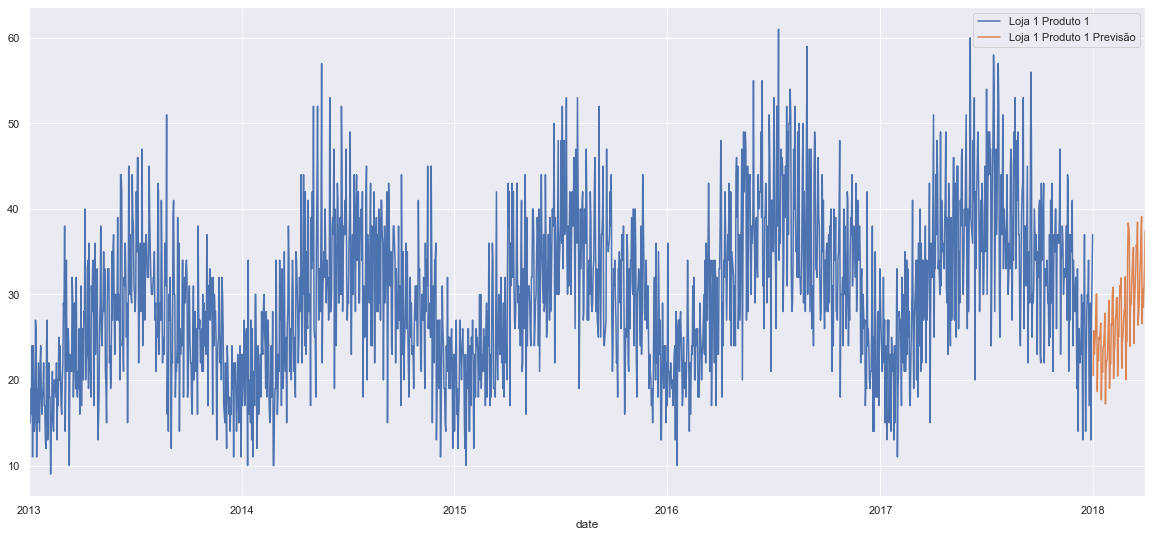

In [40]:
train_final[(train_final.store == 1) & (train_final.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Loja 1 Produto 1")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Loja 1 Produto 1 Previsão");

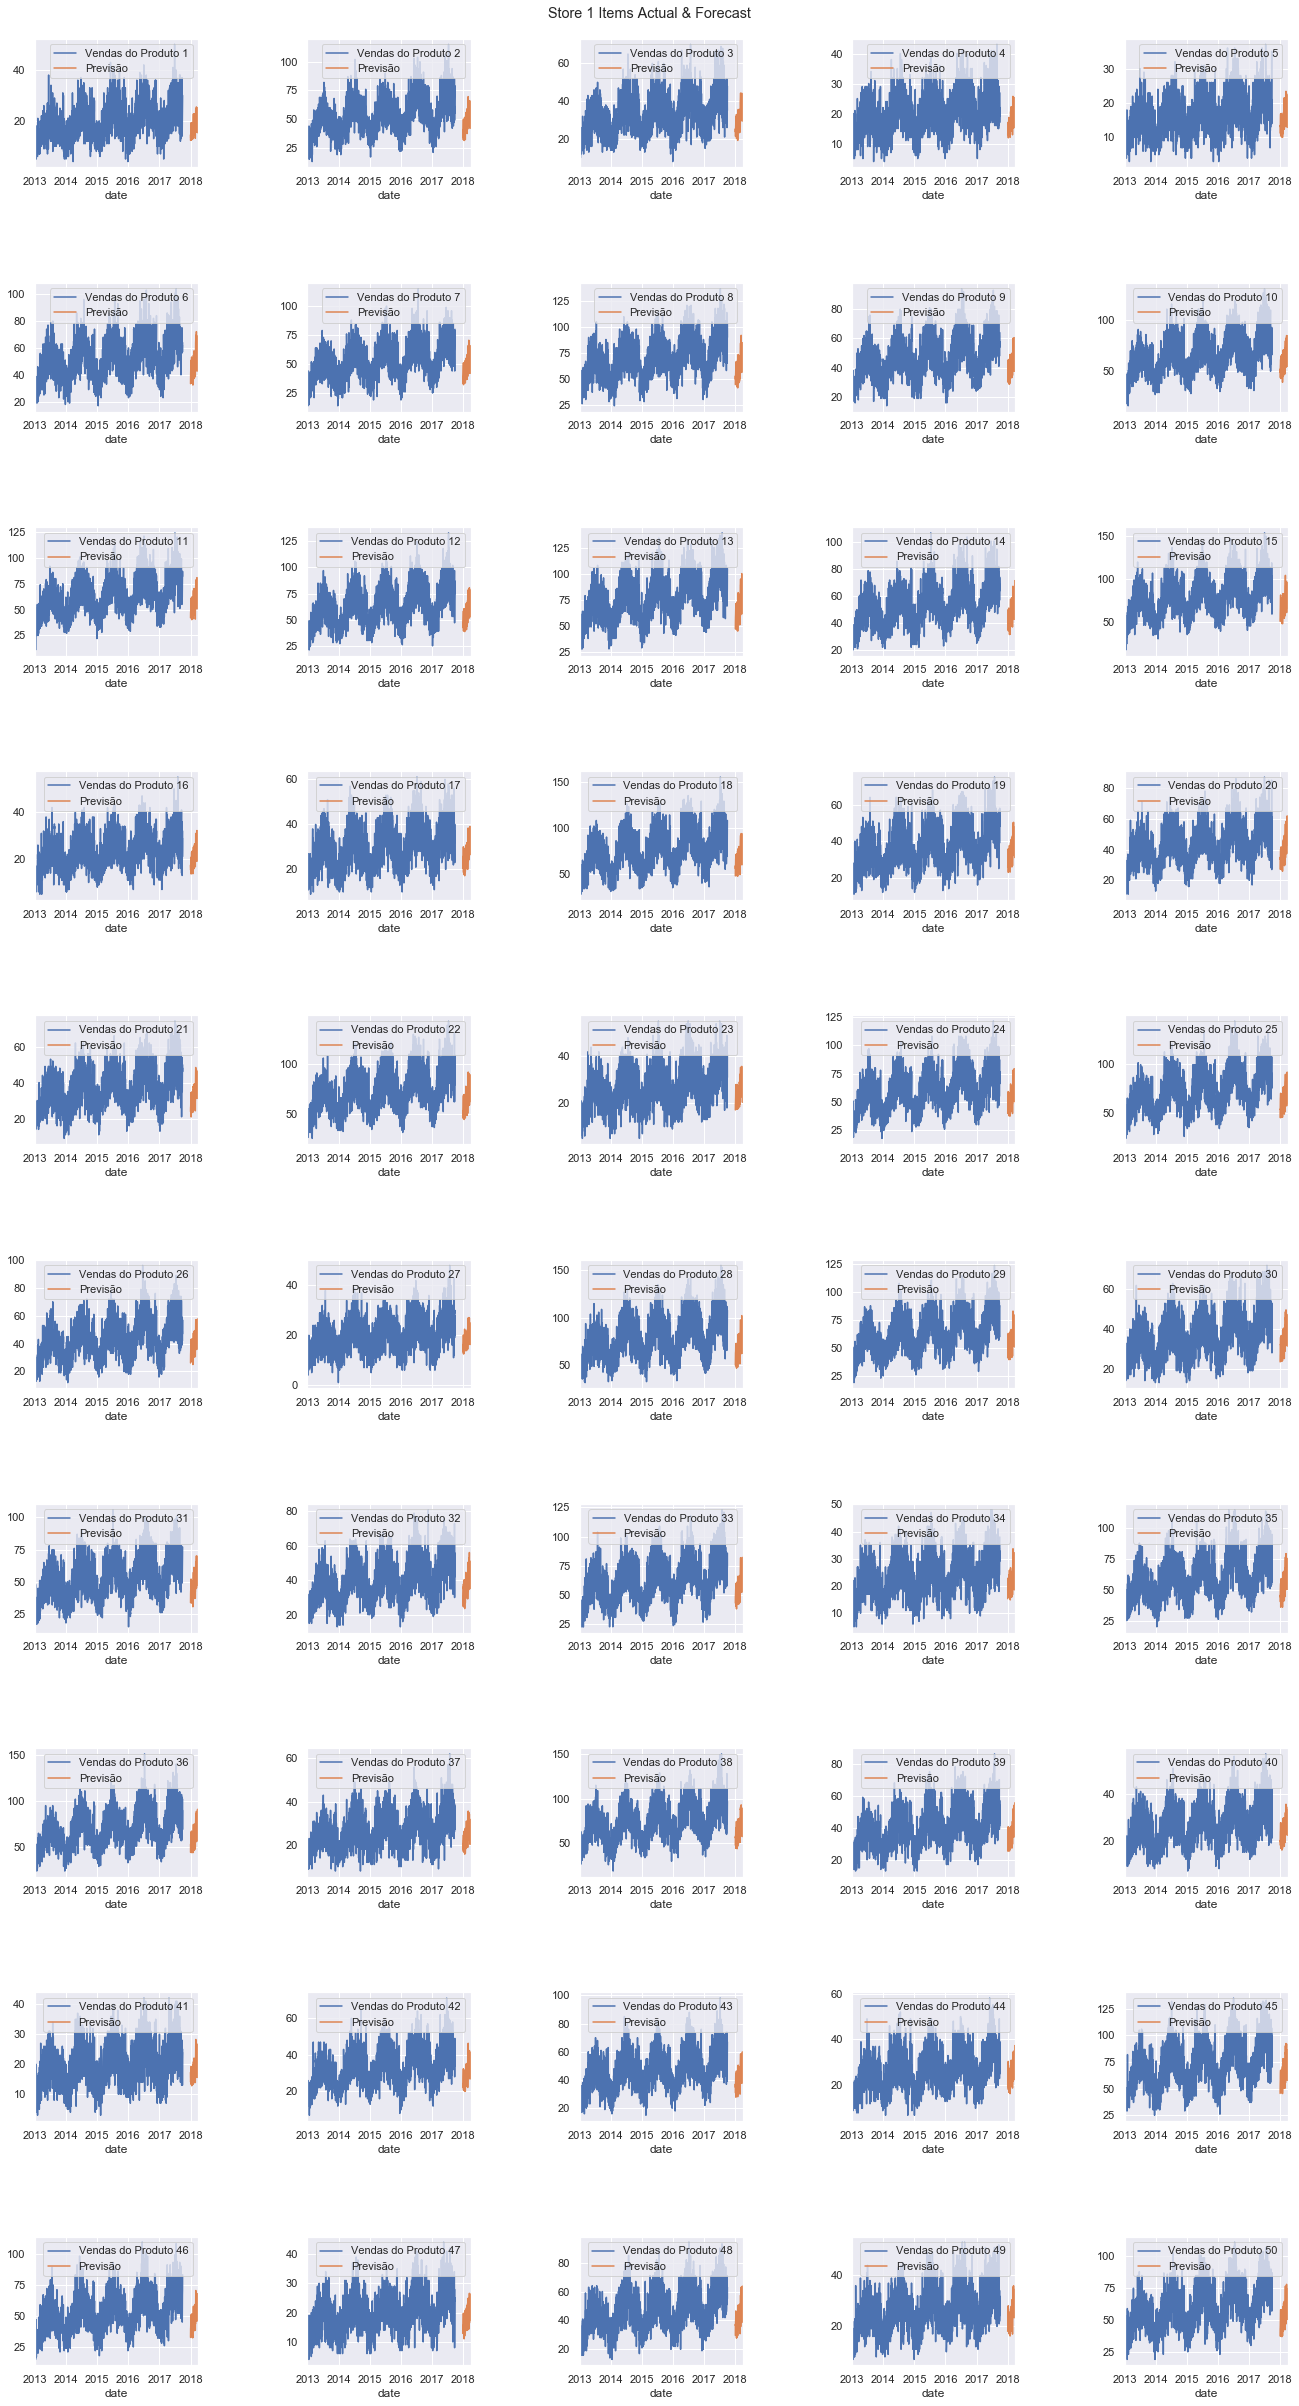

In [41]:
store = 1
sub = train[train.store == store].set_index("date")
forc = forecast[forecast.store == store].set_index("date")


fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Vendas do Produto "+str(i))
        forc[forc.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Previsão")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Vendas do Produto "+str(i))
        forc[forc.item == i].sales.plot(ax=axes[1, i-6], legend=True, label = "Previsão")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Vendas do Produto "+str(i)) 
        forc[forc.item == i].sales.plot(ax=axes[2, i-11], legend=True, label = "Previsão")
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Vendas do Produto "+str(i))    
        forc[forc.item == i].sales.plot(ax=axes[3, i-16], legend=True, label = "Previsão")
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Vendas do Produto "+str(i)) 
        forc[forc.item == i].sales.plot(ax=axes[4, i-21], legend=True, label = "Previsão")
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Vendas do Produto "+str(i))
        forc[forc.item == i].sales.plot(ax=axes[5, i-26], legend=True, label = "Previsão")
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Vendas do Produto "+str(i))  
        forc[forc.item == i].sales.plot(ax=axes[6, i-31], legend=True, label = "Previsão")
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Vendas do Produto "+str(i))
        forc[forc.item == i].sales.plot(ax=axes[7, i-36], legend=True, label = "Previsão")
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Vendas do Produto "+str(i)) 
        forc[forc.item == i].sales.plot(ax=axes[8, i-41], legend=True, label = "Previsão")
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Vendas do Produto "+str(i)) 
        forc[forc.item == i].sales.plot(ax=axes[9, i-46], legend=True, label = "Previsão")
plt.tight_layout(pad=6.5)
plt.suptitle("Real & Previsão dos Produtos da Loja 1")

## 9. Conclusão

Fomos bem sucedidos em nosso objetivo. Criamos um modelo usando o LigthGBM que foi capaz de reproduzir, dentro e uma pequeno erro, as vendas usadas como treino. No final, conseguimos definir os valores das vendas para os 3 primeirops meses de 2018.

Obsservação: Usamos apena a loja 1 como exemplo visual, mas o modelo realizou a previsão das vendas para todas as 10 lojas.